In [1]:
import os
from PIL import Image
import math
import random
from tqdm import tqdm
import imageio

import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.amp import autocast, GradScaler

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

In [ ]:
base_path = '/kaggle/input/tiny-imagenet/tiny-imagenet-200'

subset_imgs = []

for split in os.listdir(base_path):
    if split != "train":
        continue
    split_path = os.path.join(base_path, split)
    if not os.path.isdir(split_path):
        continue

    for folder in os.listdir(split_path):
        folder_path = os.path.join(split_path, folder)
        if not os.path.isdir(folder_path):
            continue

        images_path = os.path.join(folder_path, "images")
        if not os.path.isdir(images_path):
            continue

        for img in os.listdir(images_path):
            img_path = os.path.join(images_path, img)
            if not img_path.lower().endswith(("jpg", "jpeg", "png")):
                continue
            subset_imgs.append(img_path)

subset_imgs = subset_imgs[:20000]
random.shuffle(subset_imgs)

train_imgs = subset_imgs[:14000]
val_imgs   = subset_imgs[14000:17000]
test_imgs  = subset_imgs[17000:20000]

len(train_imgs), len(test_imgs), len(val_imgs)

In [4]:
class TinyImagesDataset(Dataset):
    def __init__(self, imgs, transform=None):
        super().__init__()
        self.imgs = imgs
        self.transform = transform

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        img = Image.open(self.imgs[idx]).convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img, img

In [5]:
# https://www.kaggle.com/datasets/akash2sharma/tiny-imagenet
transform = transforms.Compose([
    transforms.Resize(64),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

train_set = TinyImagesDataset(train_imgs, transform)
val_set = TinyImagesDataset(val_imgs, transform)
test_set = TinyImagesDataset(test_imgs, transform)

train_loader = DataLoader(train_set, batch_size=64, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_set, batch_size=64, shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_set, batch_size=64, shuffle=False, num_workers=2, pin_memory=True)

In [27]:
class TimeEmbeddings(nn.Module):
    def __init__(self, cout=512):
        super().__init__()
        self.cout = cout

    def forward(self, timesteps):
        half_dim = self.cout // 2
        i = torch.arange(half_dim, dtype=torch.float32, device=timesteps.device)

        exponent = -math.log(10000) * i / half_dim
        freqs = torch.exp(exponent) # (1, half_dim)
        angles = timesteps[:, None] * freqs[None, :] # (B, 1) * (1, half_dim) = (B, half_dim)

        emb = torch.zeros(timesteps.size(0), self.cout, device=timesteps.device) # (B, cout)
        emb[:, 0::2] = torch.sin(angles)
        emb[:, 1::2] = torch.cos(angles)

        return emb

In [28]:
class AttnBlock(nn.Module):
    def __init__(self, cin, n_att_heads=8):
        super().__init__() # (B, C, H, W)
        self.n_att_heads = n_att_heads
        self.head_dim = cin // n_att_heads

        self.norm = nn.GroupNorm(32, cin)
        self.qkv_proj = nn.Conv2d(cin, 3*cin, kernel_size=1)
        self.lin_proj = nn.Conv2d(cin, cin, kernel_size=1)

    def forward(self, x):
        B, C, H, W = x.shape
        x_norm = self.norm(x) # (B, C, H, W)

        qkv = self.qkv_proj(x_norm) # (B, 3*C, H, W)
        q, k, v = torch.chunk(qkv, 3, dim=1) # (B, C, H, W) each

        S = H*W
        q = q.view(B, self.n_att_heads, self.head_dim, S).transpose(2, 3) # (B, n_h, H*W, d)
        k = k.view(B, self.n_att_heads, self.head_dim, S).transpose(2, 3) # (B, n_h, H*W, d)
        v = v.view(B, self.n_att_heads, self.head_dim, S).transpose(2, 3) # (B, n_h, H*W, d)

        att = torch.softmax(q @ k.transpose(-1, -2) / (self.head_dim ** 0.5), dim=-1) # (B, n_h, H*W, H*W)
        out = att @ v # (B, n_h, H*W, d)
        out = out.transpose(2, 3).reshape(B, C, H, W) # (B, n_h*d, H, W)

        return x + self.lin_proj(out) # (B, C, H, W)

In [29]:
class ResBlock(nn.Module):
    def __init__(self, cin, cmid, cout, time_emb_dim=512, downsample=False):
        super().__init__() # (B, Cin, H, W)

        self.norm1 = nn.GroupNorm(32, cin) # (B, Cin, H, W)
        self.act1 = nn.SiLU() # (B, Cin, H, W)
        self.conv1 = nn.Conv2d(cin, cmid, kernel_size=3, padding=1) # (B, Cmid, H, W)

        self.mlp = nn.Linear(time_emb_dim, cmid) # (B, Cmid, H, W)

        self.norm2 = nn.GroupNorm(32, cmid) # (B, Cmid, H, W)
        self.act2 = nn.SiLU() # (B, Cmid, H, W)

        stride = 2 if downsample else 1

        self.conv2 = nn.Conv2d(cmid, cout, kernel_size=3, stride=stride, padding=1) # (B, Cout, H, W)

        if cin != cout or downsample:
            self.shortcut = nn.Conv2d(cin, cout, kernel_size=1, stride=stride)
        else:
            self.shortcut = nn.Identity()

    def forward(self, x, time_emb):
        out = self.conv1(self.act1(self.norm1(x))) # (B, Cmid, H, W)

        time_emb_proj = self.mlp(time_emb) # (B, Cmid)
        time_emb_proj = time_emb_proj[:, :, None, None] # (B, Cmid, 1, 1)
        out = out + time_emb_proj # (B, Cmid, H, W) via broadcasting

        out = self.conv2(self.act2(self.norm2(out))) # (B, Cout, H', W')
        return out + self.shortcut(x) # (B, Cout, H', W')

In [30]:
class EncoderBlock(nn.Module):
    def __init__(self, cin, cout, attention=False):
        super().__init__()
        self.res1 = ResBlock(cin, cin, cin)
        self.res2 = ResBlock(cin, cin, cin)
        if attention:
            self.attn = AttnBlock(cin)
        else:
            self.attn = nn.Identity()
        self.conv = nn.Conv2d(cin, cout, kernel_size=3, stride=2, padding=1)

    def forward(self, x, time_emb):
        out = self.res1(x, time_emb)
        out = self.res2(out, time_emb)
        out = self.attn(out)
        return out, self.conv(out) # pre-downsample, post-downsample

In [31]:
class Encoder(nn.Module):
    def __init__(self):
        super().__init__() # (B, 3, 64, 64)
        self.conv = nn.Conv2d(3, 128, kernel_size=3, padding=1) # (B, 128, 64, 64)
        self.block1 = EncoderBlock(128, 256) # (B, 256, 32, 32)
        self.block2 = EncoderBlock(256, 384) # (B, 384, 16, 16)
        self.block3 = EncoderBlock(384, 512, attention=True) # (B, 512, 8, 8)
        self.block4 = EncoderBlock(512, 512, attention=True) # (B, 512, 4, 4)

    def forward(self, x, time_emb):
        out = self.conv(x)
        pre_down1, out = self.block1(out, time_emb) # (B, 128, 64, 64), (B, 256, 32, 32)
        pre_down2, out = self.block2(out, time_emb) # (B, 256, 32, 32), (B, 384, 16, 16)
        pre_down3, out = self.block3(out, time_emb) # (B, 384, 16, 16), (B, 512, 8, 8)
        pre_down4, out = self.block4(out, time_emb) # (B, 512, 8, 8), (B, 512, 4, 4)
        return pre_down1, pre_down2, pre_down3, pre_down4, out

In [32]:
class Bottleneck(nn.Module):
    def __init__(self):
        super().__init__() # (B, 512, 4, 4)
        self.res1 = ResBlock(512, 512, 512)
        self.attn = AttnBlock(512)
        self.res2 = ResBlock(512, 512, 512)

    def forward(self, x, time_emb):
        return self.res2(self.attn(self.res1(x, time_emb)), time_emb)

In [33]:
class DecoderBlock(nn.Module):
    def __init__(self, cin, cout, attention=False):
        super().__init__()
        self.up = nn.ConvTranspose2d(cin, cin, kernel_size=4, stride=2, padding=1)
        self.res1 = ResBlock(cin + cout, cin + cout, cout)
        if attention:
            self.attn = AttnBlock(cout)
        else:
            self.attn = nn.Identity()
        self.res2 = ResBlock(cout, cout, cout)

    def forward(self, pre_down, x, time_emb):
        out = self.up(x)
        out = torch.concat([out, pre_down], dim=1)
        out = self.res1(out, time_emb)
        out = self.attn(out)
        return self.res2(out, time_emb)

In [34]:
class Decoder(nn.Module):
    def __init__(self):
        super().__init__() # (B, 512, 4, 4)
        self.block4 = DecoderBlock(512, 512, attention=True) # (B, 512, 8, 8)
        self.block3 = DecoderBlock(512, 384, attention=True) # (B, 384, 16, 16)
        self.block2 = DecoderBlock(384, 256) # (B, 256, 32, 32)
        self.block1 = DecoderBlock(256, 128) # (B, 128, 64, 64)
        self.norm = nn.GroupNorm(32, 128)
        self.act = nn.SiLU()
        self.conv = nn.Conv2d(128, 3, kernel_size=3, padding=1)

    def forward(self, pre_down1, pre_down2, pre_down3, pre_down4, x, time_emb):
        out = self.block4(pre_down4, x, time_emb)
        out = self.block3(pre_down3, out, time_emb)
        out = self.block2(pre_down2, out, time_emb)
        out = self.block1(pre_down1, out, time_emb)
        return self.conv(self.act(self.norm(out)))

In [35]:
class DDPM(nn.Module):
    def __init__(self):
        super().__init__()
        self.time_emb = TimeEmbeddings()
        self.encoder = Encoder()
        # self.bottleneck = Bottleneck()
        self.decoder = Decoder()

    def forward(self, x, time):
        time_emb = self.time_emb(time)
        pre_down1, pre_down2, pre_down3, pre_down4, out = self.encoder(x, time_emb)
        # out = self.bottleneck(out, time_emb)
        return self.decoder(pre_down1, pre_down2, pre_down3, pre_down4, out, time_emb)

In [17]:
def beta_linear_schedule(beta_start=1e-4, beta_end=0.02, steps=1000):
    return torch.linspace(beta_start, beta_end, steps)
    # tensor([0, 0.25, 0.5, 0.75, 1])

def get_alpha_cumprods(betas):
    alphas = 1. - betas
    alpha_bars = torch.cumprod(alphas, dim=0)
    return alpha_bars

def noisify_image(x0, t, alpha_bars):
    # x0 --> 1, c, h, w or h, w, c
    sqrt_alpha_bar = alpha_bars[t].sqrt()
    noise = torch.randn_like(x0)
    noisy_img = sqrt_alpha_bar * x0 + (1 - sqrt_alpha_bar) * noise
    return noisy_img

def noisify_images(x0, t, alpha_bars):
    # x0 --> b, c, h, w
    sqrt_alpha_bar = alpha_bars[t].sqrt().view(-1, 1, 1, 1) # (B, 1, 1, 1)
    sqrt_one_minus = (1 - alpha_bars[t]).sqrt().view(-1, 1, 1, 1) # (B, 1, 1, 1)
    noise = torch.randn_like(x0)
    return sqrt_alpha_bar * x0 + sqrt_one_minus * noise

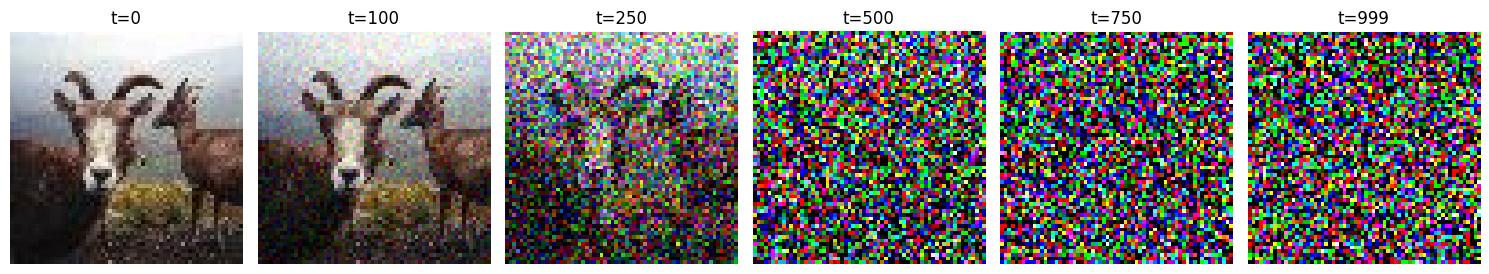

In [18]:
img = Image.open('/kaggle/input/tiny-imagenet/tiny-imagenet-200/val/images/val_1010.JPEG')
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])
x0 = transform(img).unsqueeze(0)

betas = beta_linear_schedule(0.0001, 0.02, steps=1000)
alpha_bars = get_alpha_cumprods(betas)

steps_to_visualize = [0, 100, 250, 500, 750, 999]

plt.figure(figsize=(15, 5))
for i, step in enumerate(steps_to_visualize):
    xt = noisify_image(x0, step, alpha_bars)
    img_np = xt.squeeze().permute(1, 2, 0).clamp(0, 1).detach().numpy()
    plt.subplot(1, len(steps_to_visualize), i + 1)
    plt.imshow(img_np)
    plt.title(f"t={step}")
    plt.axis("off")
plt.tight_layout()
plt.show()

In [19]:
T = 1000
betas = beta_linear_schedule(0.0001, 0.02, T).to(device)
alpha_bars = get_alpha_cumprods(betas).to(device)

In [24]:
model = DDPM().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=2e-4)
scaler = GradScaler()

num_epochs = 20
model_state_path = '/kaggle/working/runs/'
os.makedirs(model_state_path, exist_ok=True)

best_val_loss = float('inf')
patience = 4
num_cons_bad_epochs = 0

for epoch in range(num_epochs):
    train_loss = 0.0
    train_total = 0

    model.train()
    train_loop = tqdm(train_loader, desc=f"[Epoch {epoch+1}] Training", leave=False)
    for imgs, _ in train_loop:
        imgs = imgs.to(device)
        batch_size = imgs.size(0)

        timesteps = torch.randint(low=0, high=T, size=(batch_size,), device=device)
        noises = torch.randn_like(imgs)

        alpha_t = alpha_bars[timesteps].view(-1, 1, 1, 1)
        sqrt_alpha = alpha_t.sqrt()
        sqrt_one_minus = (1 - alpha_t).sqrt()
        noisy_imgs = sqrt_alpha * imgs + sqrt_one_minus * noises

        optimizer.zero_grad()

        with autocast(device_type=device):
            pred_noises = model(noisy_imgs, timesteps)
            loss = F.mse_loss(pred_noises, noises)

        train_loss += loss.item() * batch_size
        train_total += batch_size

        train_loop.set_postfix(loss=loss.item())

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

    val_loss = 0.0
    val_total = 0

    model.eval()
    val_loop = tqdm(val_loader, desc=f"[Epoch {epoch+1}] Validating", leave=False)
    with torch.no_grad():
        for imgs, _ in val_loop:
            imgs = imgs.to(device)
            batch_size = imgs.size(0)

            timesteps = torch.randint(low=0, high=T, size=(batch_size,), device=device)
            noises = torch.randn_like(imgs)

            alpha_t = alpha_bars[timesteps].view(-1, 1, 1, 1)
            sqrt_alpha = alpha_t.sqrt()
            sqrt_one_minus = (1 - alpha_t).sqrt()
            noisy_imgs = sqrt_alpha * imgs + sqrt_one_minus * noises

            with autocast(device_type=device):
                pred_noises = model(noisy_imgs, timesteps)
                loss = F.mse_loss(pred_noises, noises)

            val_loss += loss.item() * batch_size
            val_total += batch_size

            val_loop.set_postfix(val_loss=loss.item())

    avg_train_loss = train_loss / train_total
    avg_val_loss = val_loss / val_total

    print(f"[Epoch {epoch+1}] Avg Train Loss: {avg_train_loss:.4f} | Avg Val Loss: {avg_val_loss:.4f}")

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        num_cons_bad_epochs = 0
    else:
        num_cons_bad_epochs += 1
        if num_cons_bad_epochs == patience:
            print("Early stopping triggered.")
            break

    save_path = os.path.join(model_state_path, f"epoch-{epoch}.pth")
    torch.save(model.state_dict(), save_path)

[Epoch 1] Avg Train Loss: 0.1057 | Avg Val Loss: 0.0562


[Epoch 2] Avg Train Loss: 0.0538 | Avg Val Loss: 0.0532


[Epoch 3] Avg Train Loss: 0.0490 | Avg Val Loss: 0.0470


[Epoch 4] Avg Train Loss: 0.0454 | Avg Val Loss: 0.0435


[Epoch 5] Avg Train Loss: 0.0449 | Avg Val Loss: 0.0419


[Epoch 6] Avg Train Loss: 0.0433 | Avg Val Loss: 0.0421


[Epoch 7] Avg Train Loss: 0.0434 | Avg Val Loss: 0.0437


[Epoch 8] Avg Train Loss: 0.0406 | Avg Val Loss: 0.0413


[Epoch 9] Avg Train Loss: 0.0411 | Avg Val Loss: 0.0411


[Epoch 10] Avg Train Loss: 0.0394 | Avg Val Loss: 0.0393


[Epoch 11] Avg Train Loss: 0.0402 | Avg Val Loss: 0.0378


[Epoch 12] Avg Train Loss: 0.0400 | Avg Val Loss: 0.0427


[Epoch 13] Avg Train Loss: 0.0396 | Avg Val Loss: 0.0390


[Epoch 14] Avg Train Loss: 0.0399 | Avg Val Loss: 0.0385


KeyboardInterrupt: 

In [20]:
best_model_state_path = '/kaggle/input/ddpm-weights/pytorch/default/1/epoch-10.pth'
model = DDPM().to(device)
model.load_state_dict(torch.load(best_model_state_path))

model.eval()

test_loss = 0.0
test_total = 0

with torch.no_grad():
    for imgs, _ in test_loader:
        imgs = imgs.to(device)
        batch_size = imgs.size(0)
    
        timesteps = torch.randint(low=0, high=T, size=(batch_size,), device=device)
        noises = torch.randn_like(imgs)
    
        alpha_t = alpha_bars[timesteps].view(-1, 1, 1, 1)
        sqrt_alpha = alpha_t.sqrt()
        sqrt_one_minus = (1 - alpha_t).sqrt()
        noisy_imgs = sqrt_alpha * imgs + sqrt_one_minus * noises
    
        with autocast(device_type=device):
            pred_noises = model(noisy_imgs, timesteps)
            loss = F.mse_loss(pred_noises, noises)
    
        test_loss += loss.item() * batch_size
        test_total += batch_size
    
avg_test_loss = test_loss / test_total
print(f"Avg Test Loss: {avg_test_loss:.4f}")

Avg Test Loss: 0.0385


In [ ]:
best_model_state_path = '/kaggle/input/ddpm-weights/pytorch/default/1/epoch-10.pth'
model = DDPM().to(device)
model.load_state_dict(torch.load(best_model_state_path, map_location=device))

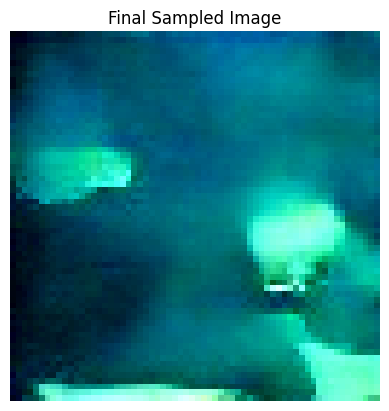

/tmp/ipykernel_35/3714296062.py:48: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images = [imageio.imread(f"{save_dir}/{f}") for f in filenames]


In [26]:
T = 1000
betas = beta_linear_schedule(0.0001, 0.02, T).to(device)
alpha_bars = get_alpha_cumprods(betas).to(device)
alphas = 1. - betas

model.eval()
curr_state = torch.randn(1, 3, 64, 64).to(device)

to_pil = transforms.ToPILImage()
save_dir = "/kaggle/working/samples"
os.makedirs(save_dir, exist_ok=True)


with torch.no_grad():
    for t in range(T - 1, -1, -1):
        timestep = torch.tensor([t], device=device)

        beta_t = betas[t]
        alpha_bar_t = alpha_bars[t]
        alpha_t = alphas[t]

        pred_noise = model(curr_state, timestep)

        coef = beta_t / torch.sqrt(1 - alpha_bar_t)
        mu_t = (1 / torch.sqrt(alpha_t)) * (curr_state - coef * pred_noise)

        if t > 0:
            eps = torch.randn_like(curr_state)
            std_t = torch.sqrt(beta_t)
            curr_state = mu_t + std_t * eps
        else:
            curr_state = mu_t

        if t % 100 == 0 or t == 0:
            img_vis = curr_state.clamp(-1, 1)
            img_vis = (img_vis + 1) / 2
            img_pil = to_pil(img_vis.squeeze(0).cpu())
            img_pil.save(f"{save_dir}/step_{t:04d}.png")


final_img = to_pil(((curr_state.clamp(-1, 1) + 1) / 2).squeeze(0).cpu())
plt.imshow(final_img)
plt.axis('off')
plt.title("Final Sampled Image")
plt.show()

filenames = sorted([f for f in os.listdir(save_dir) if f.endswith(".png")])
images = [imageio.imread(f"{save_dir}/{f}") for f in filenames]
imageio.mimsave(f"{save_dir}/denoising.gif", images, duration=0.1)